In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Define function for inferencing with TFLite model and displaying results

def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

  # Grab filenames of all images in test folder
  images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

  # Load the label map into memory
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  # Load the Tensorflow Lite model into memory
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  # print('input detail : ', input_details)

  # print('tipe data', input_details[0]['dtype'])

  input_mean = 127.5
  input_std = 127.5

  # Randomly select test images
  images_to_test = random.sample(images, num_test_images)

  # Loop over every image and perform detection
  for image_path in images_to_test:

      # Load image and resize to expected shape [1xHxWx3]
      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imH, imW, _ = image.shape
      image_resized = cv2.resize(image_rgb, (width, height))
      input_data = np.expand_dims(image_resized, axis=0)

      # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
      # print('sebelum normalisasi', input_data)
      input_data = (np.float32(input_data) - input_mean) / input_std

      # print('setelah normalisasi', input_data)
      # Perform the actual detection by running the model with the image as input
      interpreter.set_tensor(input_details[0]['index'],input_data)
      interpreter.invoke()

      # Retrieve detection results
      boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
      classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
      scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

      detections = []

      # Loop over all detections and draw detection box if confidence is above minimum threshold
      for i in range(len(scores)):
          if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

              # Get bounding box coordinates and draw box
              # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
              ymin = int(max(1,(boxes[i][0] * imH)))
              xmin = int(max(1,(boxes[i][1] * imW)))
              ymax = int(min(imH,(boxes[i][2] * imH)))
              xmax = int(min(imW,(boxes[i][3] * imW)))

              cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

              # Draw label
              object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
              label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
              labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
              label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
              cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
              cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

              detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])


      # All the results have been drawn on the image, now display the image
      if txt_only == False: # "text_only" controls whether we want to display the image results or just save them in .txt files
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,16))
        plt.imshow(image)
        plt.show()

      # Save detection results in .txt files (for calculating mAP)
      elif txt_only == True:

        # Get filenames and paths
        image_fn = os.path.basename(image_path)
        base_fn, ext = os.path.splitext(image_fn)
        txt_result_fn = base_fn +'.txt'
        txt_savepath = os.path.join(savepath, txt_result_fn)

        # Write results to text file
        # (Using format defined by https://github.com/Cartucho/mAP, which will make it easy to calculate mAP)
        with open(txt_savepath,'w') as f:
            for detection in detections:
                f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

  return

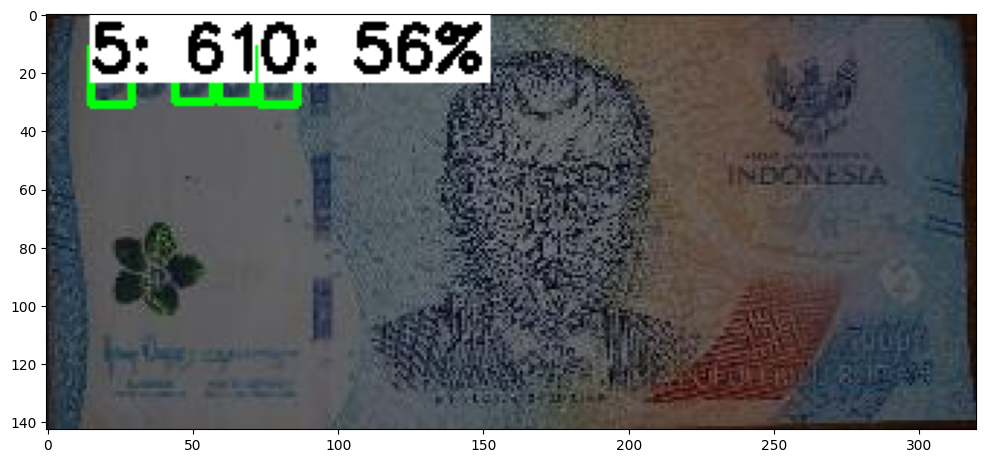

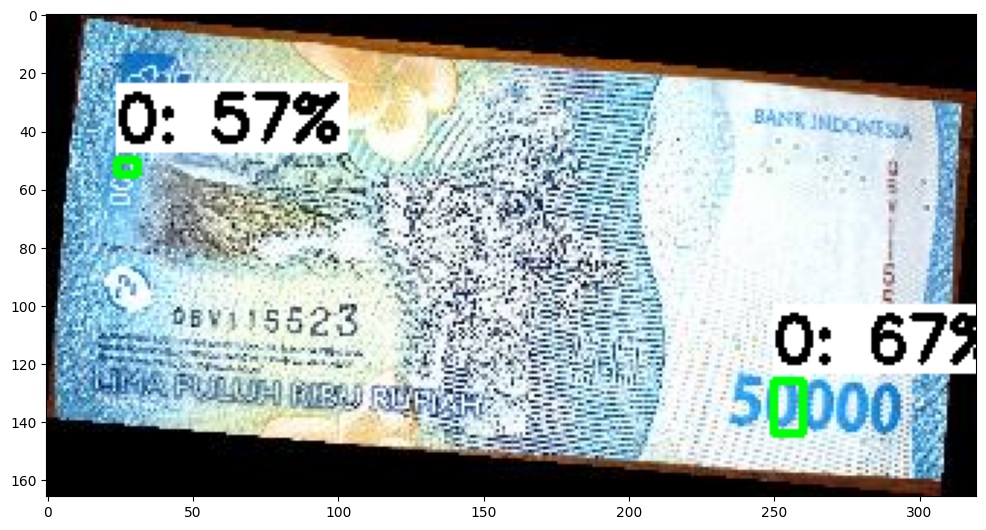

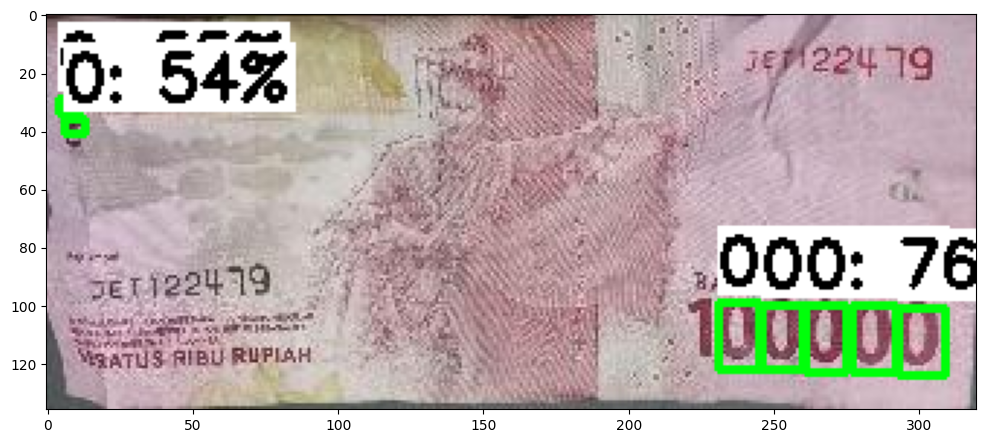

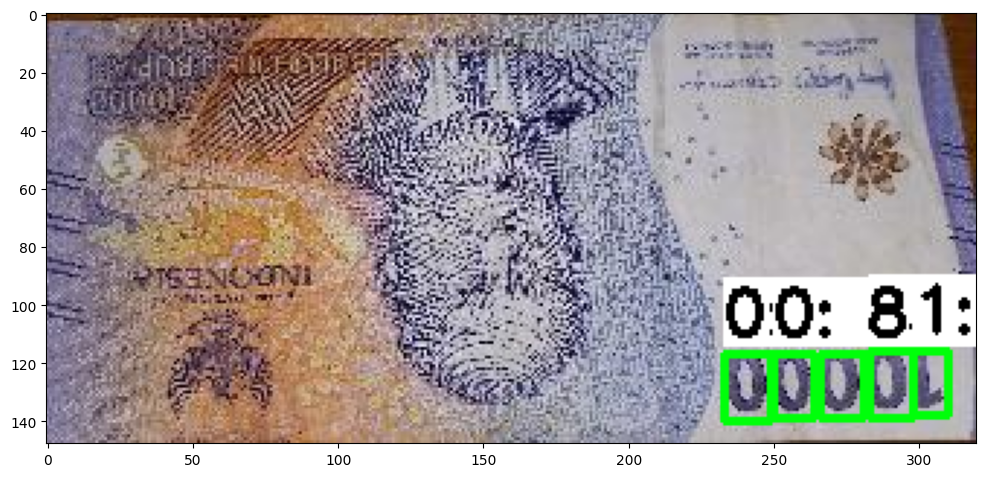

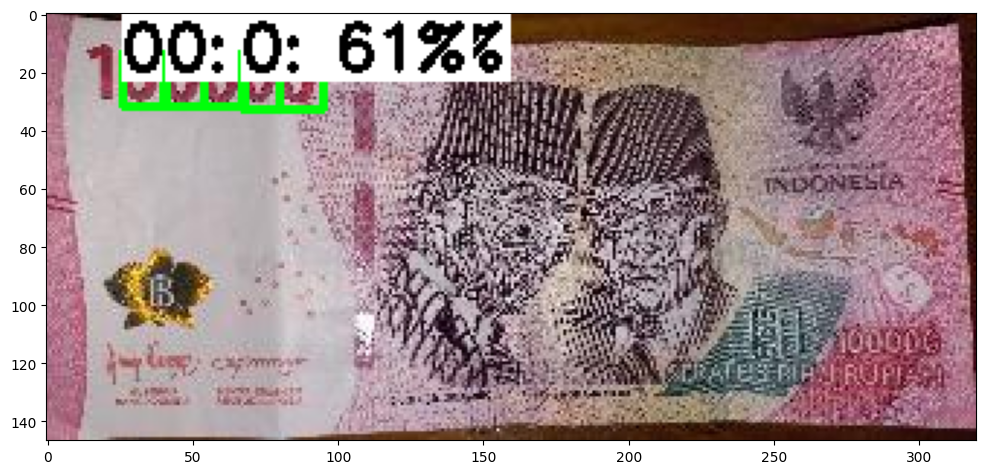

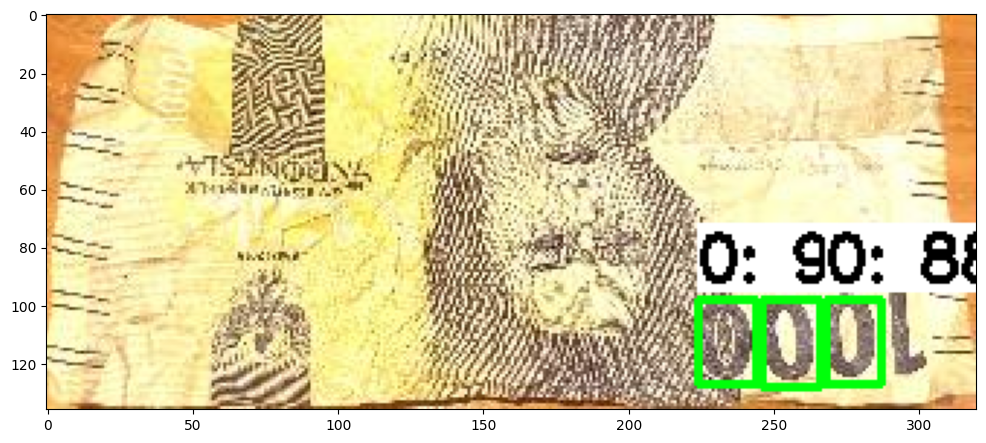

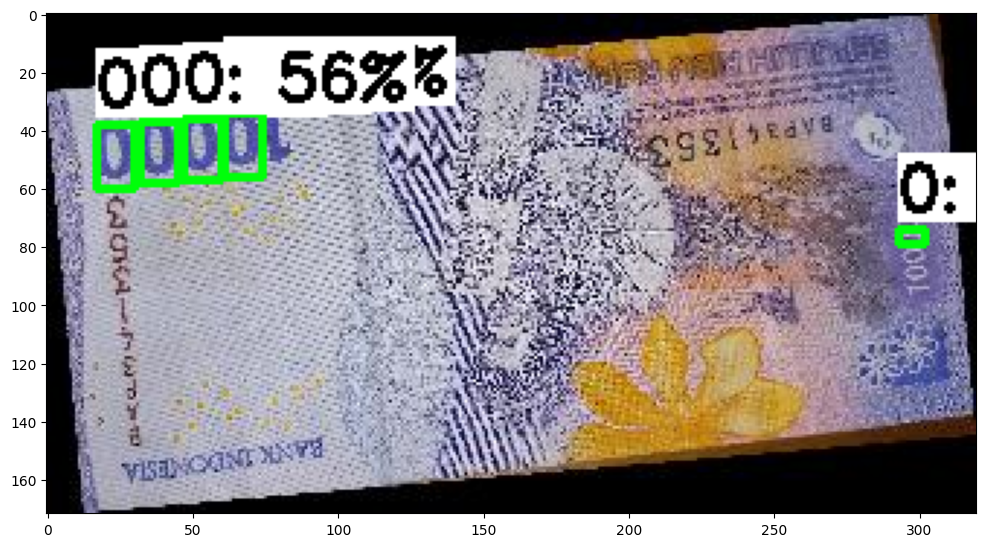

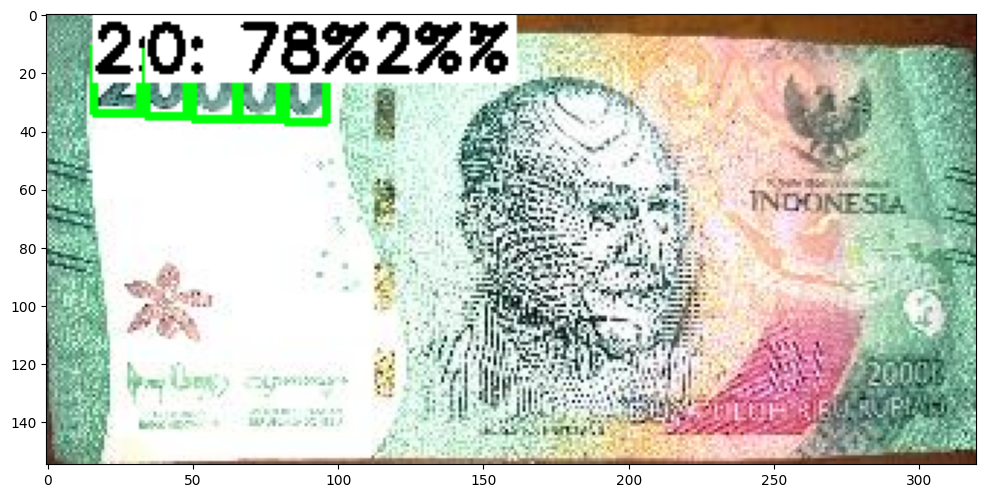

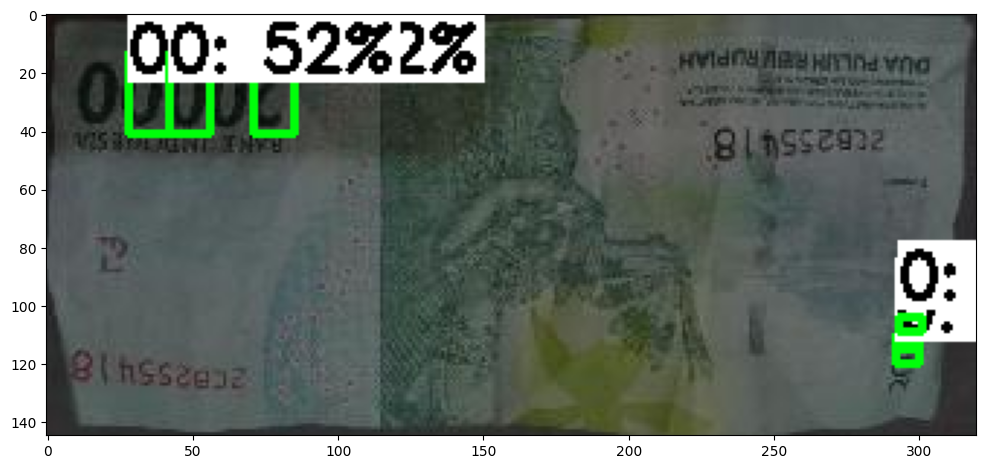

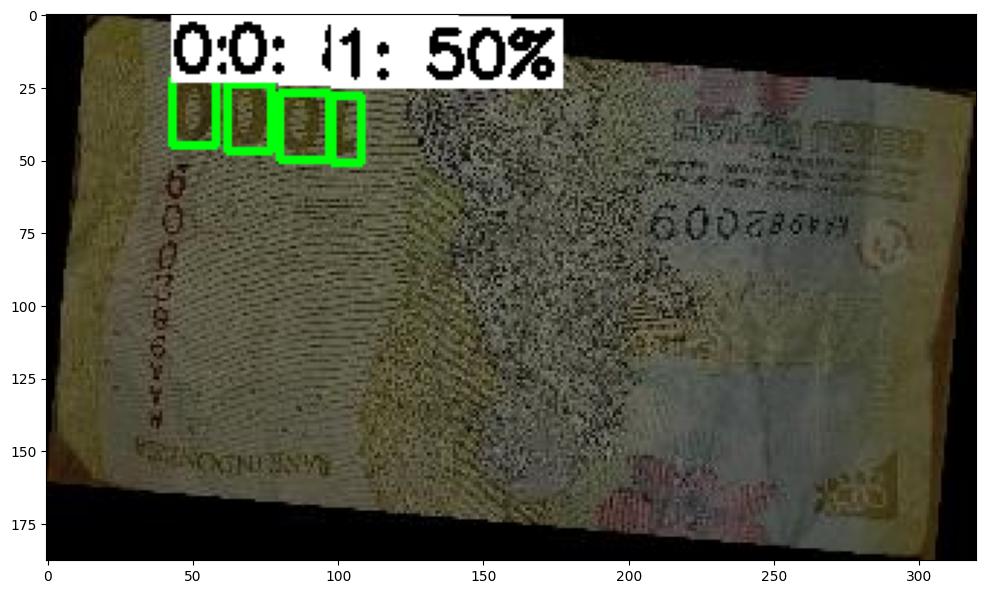

In [3]:
# Set up variables for running user's model
PATH_TO_IMAGES='/content/drive/MyDrive/image_new_money/test'   # Path to test images folder
PATH_TO_MODEL='/content/drive/MyDrive/custom_model_lite/detect.tflite'   # Path to .tflite model file
PATH_TO_LABELS='/content/drive/MyDrive/image_new_money/labelmap.txt'   # Path to labelmap.txt file
min_conf_threshold=0.5   # Confidence threshold (try changing this to 0.01 if you don't see any detection results)
images_to_test = 10   # Number of images to run detection on

# Run inferencing function!
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)

# Evaluasi MaP

In [6]:
%%bash
git clone https://github.com/Cartucho/mAP /content/drive/MyDrive/custom_model_lite/mAP
cd /content/drive/MyDrive/custom_model_lite/mAP
rm input/detection-results/*
rm input/ground-truth/*
rm input/images-optional/*
wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/calculate_map_cartucho.py

Cloning into '/content/drive/MyDrive/custom_model_lite/mAP'...
Updating files: 100% (269/269), done.
--2024-06-26 12:41:03--  https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/calculate_map_cartucho.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5397 (5.3K) [text/plain]
Saving to: ‘calculate_map_cartucho.py’

     0K .....                                                 100% 1.23M=0.004s

2024-06-26 12:41:03 (1.23 MB/s) - ‘calculate_map_cartucho.py’ saved [5397/5397]



In [7]:
!cp /content/drive/MyDrive/image_new_money/test/* /content/drive/MyDrive/custom_model_lite/mAP/input/images-optional # Copy images and xml files
!mv /content/drive/MyDrive/custom_model_lite/mAP/input/images-optional/*.xml /content/drive/MyDrive/custom_model_lite/mAP/input/ground-truth/  # Move xml files to the appropriate folder


In [8]:
!python /content/drive/MyDrive/custom_model_lite/mAP/scripts/extra/convert_gt_xml.py

Conversion completed!


In [9]:
# Set up variables for running inference, this time to get detection results saved as .txt files
PATH_TO_IMAGES='/content/drive/MyDrive/image_new_money/test'   # Path to test images folder
PATH_TO_MODEL='/content/drive/MyDrive/custom_model_lite/detect.tflite' # Path to .tflite model file
PATH_TO_LABELS='/content/drive/MyDrive/image_new_money/labelmap.txt'   # Path to labelmap.txt file
PATH_TO_RESULTS='/content/drive/MyDrive/custom_model_lite/mAP/input/detection-results' # Folder to save detection results in
min_conf_threshold=0.1   # Confidence threshold

# Use all the images in the test folder
image_list = glob.glob(PATH_TO_IMAGES + '/*.jpg') + glob.glob(PATH_TO_IMAGES + '/*.JPG') + glob.glob(PATH_TO_IMAGES + '/*.png') + glob.glob(PATH_TO_IMAGES + '/*.bmp')
images_to_test = len(image_list) # If there are more than 500 images in the folder, just use 500

# Tell function to just save results and not display images
txt_only = True

# Run inferencing function!
print('Starting inference on %d images...' % images_to_test)
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test, PATH_TO_RESULTS, txt_only)
print('Finished inferencing!')

Starting inference on 263 images...
Finished inferencing!


In [10]:
%cd /content/drive/MyDrive/custom_model_lite/mAP
!python calculate_map_cartucho.py --labels=/content/drive/MyDrive/image_new_money/labelmap.txt

/content/drive/MyDrive/custom_model_lite/mAP
Calculating mAP at 0.50 IoU threshold...
79.64% = 0 AP 
71.28% = 1 AP 
93.84% = 2 AP 
80.80% = 5 AP 
84.73% = 7 AP 
mAP = 82.06%
Calculating mAP at 0.55 IoU threshold...
75.81% = 0 AP 
68.82% = 1 AP 
92.58% = 2 AP 
77.65% = 5 AP 
79.33% = 7 AP 
mAP = 78.84%
Calculating mAP at 0.60 IoU threshold...
71.91% = 0 AP 
63.54% = 1 AP 
89.99% = 2 AP 
74.48% = 5 AP 
79.33% = 7 AP 
mAP = 75.85%
Calculating mAP at 0.65 IoU threshold...
66.33% = 0 AP 
58.48% = 1 AP 
84.43% = 2 AP 
68.40% = 5 AP 
70.92% = 7 AP 
mAP = 69.71%
Calculating mAP at 0.70 IoU threshold...
61.44% = 0 AP 
53.18% = 1 AP 
76.23% = 2 AP 
62.94% = 5 AP 
58.93% = 7 AP 
mAP = 62.54%
Calculating mAP at 0.75 IoU threshold...
56.01% = 0 AP 
46.43% = 1 AP 
72.14% = 2 AP 
59.50% = 5 AP 
56.01% = 7 AP 
mAP = 58.02%
Calculating mAP at 0.80 IoU threshold...
48.32% = 0 AP 
35.43% = 1 AP 
62.93% = 2 AP 
51.17% = 5 AP 
56.01% = 7 AP 
mAP = 50.77%
Calculating mAP at 0.85 IoU threshold...
35.25% = 0 